In [7]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3090


In [50]:
import pandas as pd
import datasets

# Load the dataset from the specified name and select the \"train\" split
dataset = pd.read_csv('data/youtoxic_english_1000.csv')
dataset.iloc[:, 3:] = dataset.iloc[:, 3:].astype(int)


# spilt into train: 800 test:100 val:100
train = dataset.iloc[:800, :]
test = dataset.iloc[800:900, :]
val = dataset.iloc[900:, :]

train.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,0,0,0,0,0,0,0,0,0,0,0,0
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,1,1,0,0,0,0,0,0,0,0,0,0
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,1,1,0,0,1,0,0,0,0,0,0,0
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,0,0,0,0,0,0,0,0,0,0,0,0
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# convert to DataDict\n",
dataset = datasets.DatasetDict({
    "train": datasets.Dataset.from_pandas(train),
    "test":datasets.Dataset.from_pandas(test),
    "val":datasets.Dataset.from_pandas(val)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism'],
        num_rows: 800
    })
    test: Dataset({
        features: ['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism'],
        num_rows: 100
    })
    val: Dataset({
        features: ['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism'],
        num_rows: 100
    })
})

In [13]:
# list of labels
labels = [label for label in dataset['train'].features.keys() if label not in ['CommentId', 'VideoId', 'Text']]
# dict map int to labels
id2label = {idx:label for idx, label in enumerate(labels)}
# dict map label to int\n",
label2id = {label:idx for idx, label in enumerate(labels)}

labels

['IsToxic',
 'IsAbusive',
 'IsThreat',
 'IsProvocative',
 'IsObscene',
 'IsHatespeech',
 'IsRacist',
 'IsNationalist',
 'IsSexist',
 'IsHomophobic',
 'IsReligiousHate',
 'IsRadicalism']

In [18]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
    # take a batch of texts
    text = examples["Text"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding

In [19]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [20]:
example = encoded_dataset['train'][1]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [21]:
example['labels']

[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [22]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['IsToxic', 'IsAbusive']

In [24]:
# format data to PyTorch tensors (PyTorch datasets)
encoded_dataset.set_format("torch")

In [28]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

# Define LoRA Config
lora_config = LoraConfig(
    r=1024,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.01,
    bias="none",
    task_type=TaskType.SEQ_CLS, # this is necessary
    inference_mode=True
)

# add LoRA adaptor
model = get_peft_model(model, lora_config)
model.print_trainable_parameters() # see % trainable parameters

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 9,228 || all params: 147,249,432 || trainable%: 0.00626691721296419


In [29]:
batch_size = 8
metric_name = "f1"

In [31]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=50,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name
)

2024-02-29 21:14:31.209412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 21:14:31.209450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 21:14:31.210577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 21:14:31.216401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 21:14:31.793303: W tensorflow/compiler/tf2

In [32]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [33]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [34]:
encoded_dataset['train'][0]['input_ids'][0]

tensor(101)

In [35]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.6690, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.3546,  0.3935, -0.3240, -0.2722, -0.1161, -0.2904, -0.2314, -0.3130,
         -0.2744,  0.4917,  0.4246, -0.0142]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [36]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [37]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lyt4 (wit_thesis). Use `wandb login --relogin` to force relogin


  0%|          | 0/2500 [00:00<?, ?it/s]

/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.5577065944671631, 'eval_f1': 0.11656441717791412, 'eval_roc_auc': 0.4894957983193277, 'eval_accuracy': 0.08, 'eval_runtime': 0.3717, 'eval_samples_per_second': 269.034, 'eval_steps_per_second': 18.832, 'epoch': 1.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.4661443829536438, 'eval_f1': 0.08219178082191782, 'eval_roc_auc': 0.5201791242812915, 'eval_accuracy': 0.51, 'eval_runtime': 0.3691, 'eval_samples_per_second': 270.91, 'eval_steps_per_second': 18.964, 'epoch': 2.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.4033013880252838, 'eval_f1': 0.08333333333333334, 'eval_roc_auc': 0.5211189739053517, 'eval_accuracy': 0.52, 'eval_runtime': 0.3675, 'eval_samples_per_second': 272.104, 'eval_steps_per_second': 19.047, 'epoch': 3.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3653832972049713, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3697, 'eval_samples_per_second': 270.512, 'eval_steps_per_second': 18.936, 'epoch': 4.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.34185996651649475, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3698, 'eval_samples_per_second': 270.419, 'eval_steps_per_second': 18.929, 'epoch': 5.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3260863423347473, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3714, 'eval_samples_per_second': 269.236, 'eval_steps_per_second': 18.847, 'epoch': 6.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3151426315307617, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3683, 'eval_samples_per_second': 271.537, 'eval_steps_per_second': 19.008, 'epoch': 7.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3071576952934265, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3822, 'eval_samples_per_second': 261.611, 'eval_steps_per_second': 18.313, 'epoch': 8.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.3011840581893921, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3687, 'eval_samples_per_second': 271.238, 'eval_steps_per_second': 18.987, 'epoch': 9.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4017, 'learning_rate': 1.6000000000000003e-05, 'epoch': 10.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2961372435092926, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3696, 'eval_samples_per_second': 270.592, 'eval_steps_per_second': 18.941, 'epoch': 10.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2920396029949188, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3682, 'eval_samples_per_second': 271.596, 'eval_steps_per_second': 19.012, 'epoch': 11.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2886243164539337, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3689, 'eval_samples_per_second': 271.058, 'eval_steps_per_second': 18.974, 'epoch': 12.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.28594809770584106, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3692, 'eval_samples_per_second': 270.829, 'eval_steps_per_second': 18.958, 'epoch': 13.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.28383931517601013, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.368, 'eval_samples_per_second': 271.752, 'eval_steps_per_second': 19.023, 'epoch': 14.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2815670371055603, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3672, 'eval_samples_per_second': 272.329, 'eval_steps_per_second': 19.063, 'epoch': 15.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2801084518432617, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3686, 'eval_samples_per_second': 271.331, 'eval_steps_per_second': 18.993, 'epoch': 16.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.27868378162384033, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3667, 'eval_samples_per_second': 272.721, 'eval_steps_per_second': 19.09, 'epoch': 17.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2770821154117584, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3669, 'eval_samples_per_second': 272.529, 'eval_steps_per_second': 19.077, 'epoch': 18.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.27620720863342285, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3665, 'eval_samples_per_second': 272.853, 'eval_steps_per_second': 19.1, 'epoch': 19.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.2903, 'learning_rate': 1.2e-05, 'epoch': 20.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2754775583744049, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3713, 'eval_samples_per_second': 269.351, 'eval_steps_per_second': 18.855, 'epoch': 20.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.274238646030426, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3697, 'eval_samples_per_second': 270.46, 'eval_steps_per_second': 18.932, 'epoch': 21.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2733856439590454, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3682, 'eval_samples_per_second': 271.623, 'eval_steps_per_second': 19.014, 'epoch': 22.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2726587951183319, 'eval_f1': 0.08219178082191782, 'eval_roc_auc': 0.5201791242812915, 'eval_accuracy': 0.5, 'eval_runtime': 0.3693, 'eval_samples_per_second': 270.797, 'eval_steps_per_second': 18.956, 'epoch': 23.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.27197325229644775, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3689, 'eval_samples_per_second': 271.087, 'eval_steps_per_second': 18.976, 'epoch': 24.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2711889147758484, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.369, 'eval_samples_per_second': 271.004, 'eval_steps_per_second': 18.97, 'epoch': 25.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2708056569099426, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3684, 'eval_samples_per_second': 271.443, 'eval_steps_per_second': 19.001, 'epoch': 26.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2703525424003601, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3689, 'eval_samples_per_second': 271.082, 'eval_steps_per_second': 18.976, 'epoch': 27.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2698003351688385, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3687, 'eval_samples_per_second': 271.245, 'eval_steps_per_second': 18.987, 'epoch': 28.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2693668007850647, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3706, 'eval_samples_per_second': 269.799, 'eval_steps_per_second': 18.886, 'epoch': 29.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.2761, 'learning_rate': 8.000000000000001e-06, 'epoch': 30.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2690783739089966, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3685, 'eval_samples_per_second': 271.351, 'eval_steps_per_second': 18.995, 'epoch': 30.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2689478397369385, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.5368, 'eval_samples_per_second': 186.274, 'eval_steps_per_second': 13.039, 'epoch': 31.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2684464156627655, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3723, 'eval_samples_per_second': 268.567, 'eval_steps_per_second': 18.8, 'epoch': 32.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26824232935905457, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3685, 'eval_samples_per_second': 271.384, 'eval_steps_per_second': 18.997, 'epoch': 33.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26796209812164307, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3739, 'eval_samples_per_second': 267.485, 'eval_steps_per_second': 18.724, 'epoch': 34.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2677533030509949, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3739, 'eval_samples_per_second': 267.431, 'eval_steps_per_second': 18.72, 'epoch': 35.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26758646965026855, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.369, 'eval_samples_per_second': 270.981, 'eval_steps_per_second': 18.969, 'epoch': 36.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26733824610710144, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3704, 'eval_samples_per_second': 269.985, 'eval_steps_per_second': 18.899, 'epoch': 37.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26718512177467346, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3694, 'eval_samples_per_second': 270.677, 'eval_steps_per_second': 18.947, 'epoch': 38.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26703694462776184, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.367, 'eval_samples_per_second': 272.497, 'eval_steps_per_second': 19.075, 'epoch': 39.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.271, 'learning_rate': 4.000000000000001e-06, 'epoch': 40.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26698702573776245, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3692, 'eval_samples_per_second': 270.857, 'eval_steps_per_second': 18.96, 'epoch': 40.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26683521270751953, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.5471, 'eval_samples_per_second': 182.797, 'eval_steps_per_second': 12.796, 'epoch': 41.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.266732782125473, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3693, 'eval_samples_per_second': 270.819, 'eval_steps_per_second': 18.957, 'epoch': 42.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.266571581363678, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3703, 'eval_samples_per_second': 270.039, 'eval_steps_per_second': 18.903, 'epoch': 43.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26648619771003723, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3688, 'eval_samples_per_second': 271.13, 'eval_steps_per_second': 18.979, 'epoch': 44.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2664312422275543, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.5496, 'eval_samples_per_second': 181.948, 'eval_steps_per_second': 12.736, 'epoch': 45.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2664244771003723, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3709, 'eval_samples_per_second': 269.585, 'eval_steps_per_second': 18.871, 'epoch': 46.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26633960008621216, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3681, 'eval_samples_per_second': 271.675, 'eval_steps_per_second': 19.017, 'epoch': 47.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.26629164814949036, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3727, 'eval_samples_per_second': 268.305, 'eval_steps_per_second': 18.781, 'epoch': 48.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2662726938724518, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3685, 'eval_samples_per_second': 271.386, 'eval_steps_per_second': 18.997, 'epoch': 49.0}


/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.269, 'learning_rate': 0.0, 'epoch': 50.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.2662670910358429, 'eval_f1': 0.08275862068965519, 'eval_roc_auc': 0.5206490490933215, 'eval_accuracy': 0.51, 'eval_runtime': 0.3736, 'eval_samples_per_second': 267.671, 'eval_steps_per_second': 18.737, 'epoch': 50.0}
{'train_runtime': 271.8571, 'train_samples_per_second': 147.136, 'train_steps_per_second': 9.196, 'train_loss': 0.301618603515625, 'epoch': 50.0}


TrainOutput(global_step=2500, training_loss=0.301618603515625, metrics={'train_runtime': 271.8571, 'train_samples_per_second': 147.136, 'train_steps_per_second': 9.196, 'train_loss': 0.301618603515625, 'epoch': 50.0})

In [38]:
log = pd.DataFrame(trainer.state.log_history)
log.head()

,eval_loss,eval_f1,eval_roc_auc,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,loss,learning_rate,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.557707,0.116564,0.489496,0.08,0.3717,269.034,18.832,1.0,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.466144,0.082192,0.520179,0.51,0.3691,270.910,18.964,2.0,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.403301,0.083333,0.521119,0.52,0.3675,272.104,19.047,3.0,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.365383,0.082759,0.520649,0.51,0.3697,270.512,18.936,4.0,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.341860,0.082759,0.520649,0.51,0.3698,270.419,18.929,5.0,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN


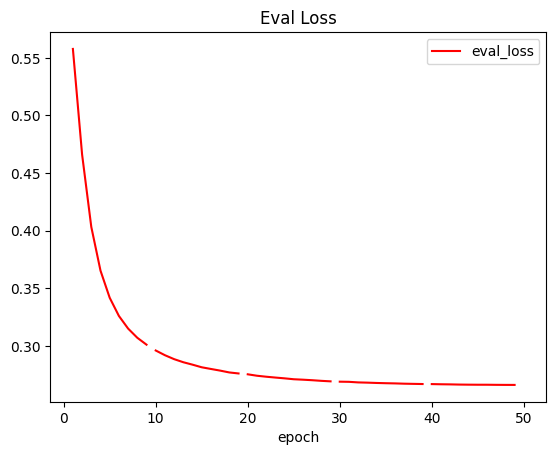

In [39]:
import matplotlib.pyplot as plt

log.plot(kind='line',
        x='epoch',
        y='eval_loss',
        color='red'
)

plt.title('Eval Loss')
plt.show()

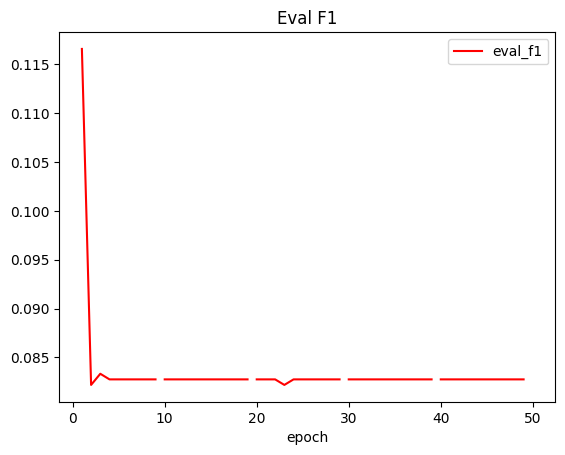

In [40]:
log.plot(kind='line',
        x='epoch',
        y='eval_f1',
        color='red'
)

plt.title('Eval F1')
plt.show()

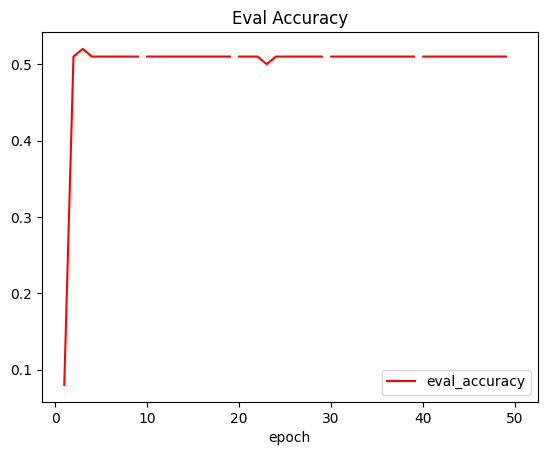

In [42]:
import matplotlib.pyplot as plt

log.plot(kind='line',
        x='epoch',
        y='eval_accuracy',
        color='red'
)

plt.title('Eval Accuracy')
plt.show()

In [44]:
trainer.evaluate(eval_dataset=encoded_dataset['test'])

/home/lambda5/Desktop/Thesis_Lyt4/venv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.5507745146751404,
 'eval_f1': 0.10489510489510488,
 'eval_roc_auc': 0.49534338242902975,
 'eval_accuracy': 0.1,
 'eval_runtime': 0.4195,
 'eval_samples_per_second': 238.398,
 'eval_steps_per_second': 16.688,
 'epoch': 50.0}

In [45]:
text = "Asians should not be on the road since they are terrible drivers"

encodings = tokenizer(text, return_tensors='pt')
encodings = {k: v.to(trainer.model.device) for k,v in encodings.items()}

outputs = trainer.model(**encodings)

In [46]:
logits = outputs.logits
logits.shape

torch.Size([1, 12])

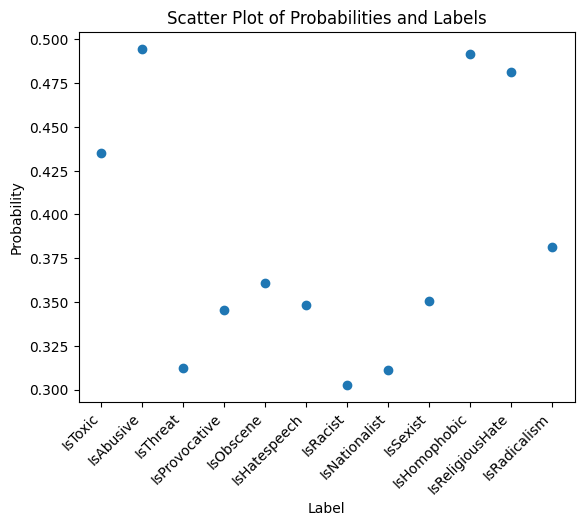

In [48]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())

plt.scatter(range(len(labels)), probs.detach().numpy())

plt.title('Probability')
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")  # Rotate labels for better readability
plt.xlabel("Label")
plt.ylabel("Probability")
plt.title("Scatter Plot of Probabilities and Labels")

plt.show()

preds = np.zeros(probs.shape)
preds[np.where(probs >= 0.4)] = 1

In [49]:
# turn predictions id into labels
pred_labels = [id2label[idx] for idx, label in enumerate(preds) if label == 1.0]
print(pred_labels)

['IsToxic', 'IsAbusive', 'IsHomophobic', 'IsReligiousHate']
